In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import csv
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from numpy import array,asarray,zeros
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Embedding, LSTM, SpatialDropout1D
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D  
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint 

# 50Agree

In [ ]:
train_file = 'without_test_50Agree_binary.txt'
test_file = 'test_set_binary.txt'
delimiter = ','

In [ ]:
df = pd.read_csv(train_file)

In [ ]:
df

,Sentiment,News
0,positive,new production plant company would increase ca...
1,positive,financing aspocomp s growth aspocomp aggressiv...
2,positive,last quarter 2010 componenta s net sale double...
3,positive,third quarter 2010 net sale increase 52 eur 20...
4,positive,operating profit total eur 211 mn eur 186 mn 2...
...,...,...
1374,negative,finland s hobby hall s sale decrease 10 intern...
1375,negative,baltic state company report net sale eur 119 m...
1376,negative,sales finland decrease 20 international sale d...
1377,negative,helsinki thomson financial shares cargotec fel...


In [ ]:
df1 = pd.read_csv(test_file)

In [ ]:
df1

,Sentiment,News
0,negative,company say comparable operating profit januar...
1,positive,metso supply equipment two process line northl...
2,negative,staff reduction start immediately glaston add
3,positive,finland insurance company pohjola finnish moto...
4,positive,item include restructuring cost eur1 6 year ea...
...,...,...
583,positive,glad long cooperation sodra continue comment ...
584,positive,operating profit turnover sixmonth period incr...
585,positive,actions improve operational efficiency adjust ...
586,positive,diluted loss per share stood eur 015 versus eu...


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

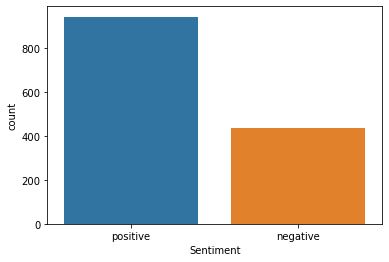

In [ ]:
sns.countplot(x='Sentiment', data=df)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

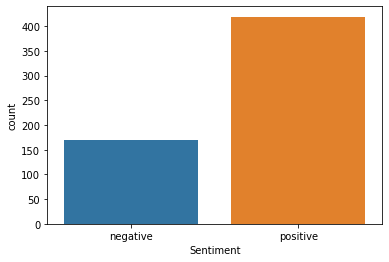

In [ ]:
sns.countplot(x='Sentiment', data=df1)

In [ ]:
X_train = list()
y_train = list()
with open(train_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_train.append(row[1])
        y_train.append(row[0])

X_test = list()
y_test = list()
with open(test_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_test.append(row[1])
        y_test.append(row[0])

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

(1379, 1379, 588, 588)

In [ ]:
y_train = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_train)))

In [ ]:
y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_test)))

In [ ]:
X_test

['company say comparable operating profit januaryjune period fell short last year s correspond performance',
 'metso supply equipment two process line northland resources new kaunisvaara iron ore project sweden exploit tapuli sahavaara iron ore deposit',
 'staff reduction start immediately glaston add',
 'finland insurance company pohjola finnish motorcyclist association sign agreement aim improve motorcyclist traffic safety',
 'item include restructuring cost eur1 6 year earlier eur13 1 m diluted eps stood eur0 3 versus loss per share eur 01',
 'operating profit rise eur 47 mn eur 36 mn',
 'outokumpu s steel mill tornio finland suspect source',
 'upmkymmene generate seventeen consecutive quarter positive cash flow operations',
 ' demand sport equipment good 2005',
 'baltic country sale fell 426',
 'finnish telecom software developer tecnomen oyj say december 5 2006 33 mln 25 mln euro order supply expansion charge message system mobile fix network brasil telecom',
 'vaisala group succe

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_test1 = tokenizer.texts_to_sequences(X_test)

In [ ]:
len(X_train1),len(X_test1)

(1379, 588)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

#we perform padding on both train and test set
#we perform padding in order to have sequences of the same length
X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

In [ ]:
#we use glove embeddings to create a dictionary
#that will contain words as keys and their corresponding
#embeddings list as values
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
#we create an embedding matrix where each row number
#will correspond to the index of the word in the corpus
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Simple Neural Network

In [ ]:
#trainable=false because we are not training our own embeddings,
#but glove embeddings
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          442000    
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 452,001
Trainable params: 10,001
Non-trainable params: 442,000
_________________________________________________________________
None


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_acc', 
    patience=2, 
    min_delta=0.001, 
    mode='max'
)

history = model.fit(X_train1, y_train, batch_size=32, epochs=10, verbose=1,
    callbacks=[early_stopping], validation_split=0.2)
score = model.evaluate(X_test1, y_test, verbose=1)

Epoch 1/10
35/35 [==============================] - 1s 7ms/step - loss: 0.4499 - acc: 0.8459 - val_loss: 1.8248 - val_acc: 0.0000e+00
Epoch 2/10
35/35 [==============================] - 0s 3ms/step - loss: 0.3485 - acc: 0.8595 - val_loss: 1.7223 - val_acc: 0.0000e+00
Epoch 3/10
35/35 [==============================] - 0s 3ms/step - loss: 0.3062 - acc: 0.8694 - val_loss: 1.7790 - val_acc: 0.0036
Epoch 4/10
35/35 [==============================] - 0s 3ms/step - loss: 0.2732 - acc: 0.8803 - val_loss: 1.8814 - val_acc: 0.0145
Epoch 5/10
35/35 [==============================] - 0s 3ms/step - loss: 0.2482 - acc: 0.8966 - val_loss: 2.0203 - val_acc: 0.0145
Epoch 6/10
35/35 [==============================] - 0s 3ms/step - loss: 0.2270 - acc: 0.9057 - val_loss: 1.9303 - val_acc: 0.0435
Epoch 7/10
35/35 [==============================] - 0s 3ms/step - loss: 0.2104 - acc: 0.9157 - val_loss: 1.8862 - val_acc: 0.0543
Epoch 8/10
35/35 [==============================] - 0s 3ms/step - loss: 0.1953 - a

In [ ]:
yhat_probs = model.predict(X_test1, verbose=0)
# predict classes for test set
yhat_classes = (model.predict(X_test1) > 0.5).astype("int32")

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.724490
Precision: 0.724258
Recall: 0.990453
F1 score: 0.836694


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.076279
ROC AUC: 0.702137
[[ 11 158]
 [  4 415]]


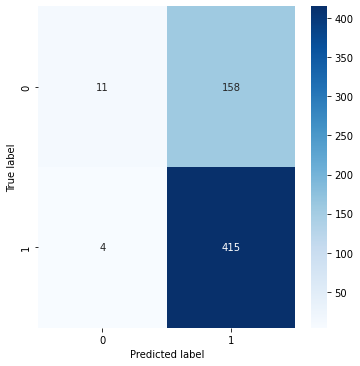

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred=model.predict(X_test1)

0.7021366736806429


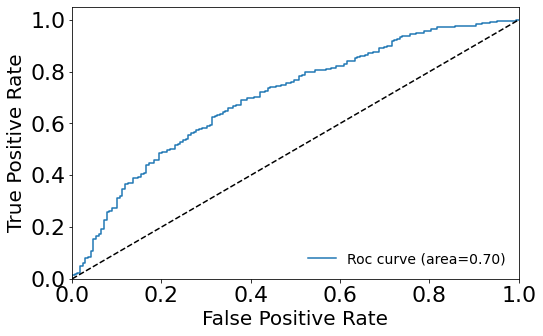

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [ ]:
value = randint(0,len(X_test)) 
instance = X_test[value]
instance

'original name componenta àmñl subsidiary finnish componenta group change àmñl components company see 63 growth q1 2010 comparison q1 2009'

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

predictions = model.predict(instance)
y_pred = (predictions > 0.5)

In [ ]:
score = model.evaluate(X_test1, y_test, verbose=1)

19/19 [==============================] - 0s 2ms/step - loss: 0.6649 - acc: 0.7245


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6649258732795715
Test Accuracy: 0.7244898080825806


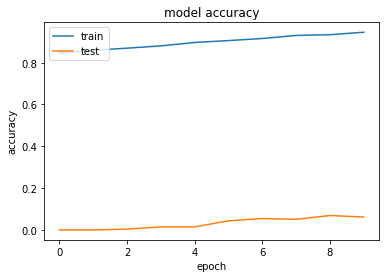

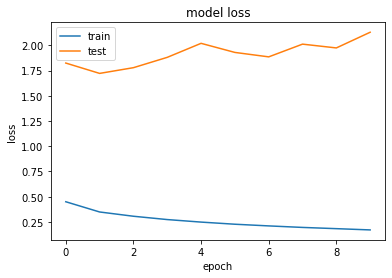

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
model1 = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model1.add(embedding_layer)

model1.add(Conv1D(128, 5, activation='relu'))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          442000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 506,257
Trainable params: 64,257
Non-trainable params: 442,000
_________________________________________________________________
None


In [ ]:
num_epochs = 10
num_batch_size = 32

history = model1.fit(X_train1, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model1.evaluate(X_test1, y_test, verbose=1)

Epoch 1/10
35/35 [==============================] - 1s 15ms/step - loss: 0.5203 - acc: 0.7996 - val_loss: 1.4658 - val_acc: 0.0109
Epoch 2/10
35/35 [==============================] - 0s 12ms/step - loss: 0.2789 - acc: 0.8794 - val_loss: 1.7888 - val_acc: 0.0290
Epoch 3/10
35/35 [==============================] - 0s 12ms/step - loss: 0.1978 - acc: 0.9157 - val_loss: 1.6266 - val_acc: 0.0870
Epoch 4/10
35/35 [==============================] - 0s 12ms/step - loss: 0.1492 - acc: 0.9601 - val_loss: 1.9806 - val_acc: 0.0797
Epoch 5/10
35/35 [==============================] - 0s 12ms/step - loss: 0.1123 - acc: 0.9737 - val_loss: 1.7487 - val_acc: 0.1232
Epoch 6/10
35/35 [==============================] - 0s 12ms/step - loss: 0.0856 - acc: 0.9873 - val_loss: 2.1815 - val_acc: 0.0870
Epoch 7/10
19/19 [==============================] - 0s 5ms/step - loss: 0.6994 - acc: 0.7449


In [ ]:
yhat_probs = model1.predict(X_test1, verbose=0)
# predict classes for test set
yhat_classes = (model1.predict(X_test1) > 0.5).astype("int32")

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.744898
Precision: 0.740608
Recall: 0.988067
F1 score: 0.846626


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.172779
ROC AUC: 0.789948
[[ 24 145]
 [  5 414]]


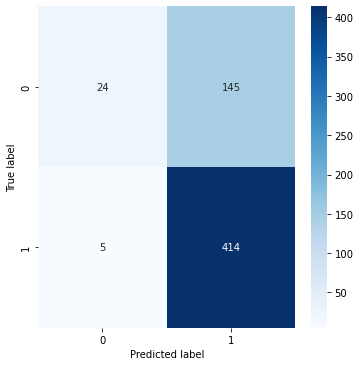

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred=model1.predict(X_test1)

0.7899478894522036


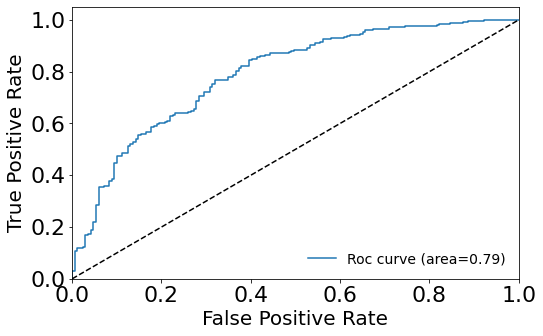

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6994289755821228
Test Accuracy: 0.7448979616165161


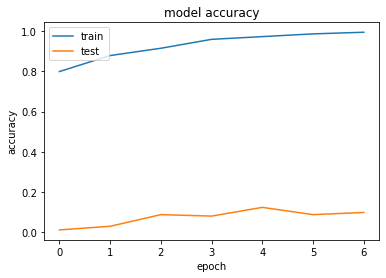

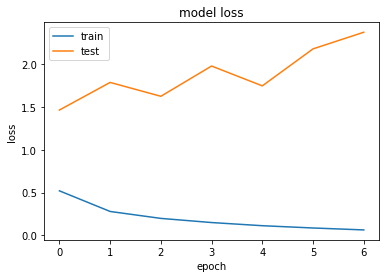

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Recurrent Neural Networl - LSTM

In [ ]:
model2 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model2.add(embedding_layer)
model2.add(LSTM(128))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          442000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 559,377
Trainable params: 117,377
Non-trainable params: 442,000
_________________________________________________________________
None


In [ ]:
history = model2.fit(X_train1, y_train, batch_size=32, epochs=10, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model2.evaluate(X_test1, y_test, verbose=1)

Epoch 1/10
35/35 [==============================] - 5s 77ms/step - loss: 0.4721 - acc: 0.8404 - val_loss: 1.6296 - val_acc: 0.0000e+00
Epoch 2/10
35/35 [==============================] - 2s 65ms/step - loss: 0.4192 - acc: 0.8558 - val_loss: 1.9129 - val_acc: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 1s 26ms/step - loss: 0.6303 - acc: 0.7126


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6302528381347656
Test Accuracy: 0.7125850319862366


In [ ]:
yhat_probs = model2.predict(X_test1, verbose=0)
# predict classes for test set
yhat_classes = (model2.predict(X_test1) > 0.5).astype("int32")

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.712585
Precision: 0.712585
Recall: 1.000000
F1 score: 0.832175


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.000000
ROC AUC: 0.553953
[[  0 169]
 [  0 419]]


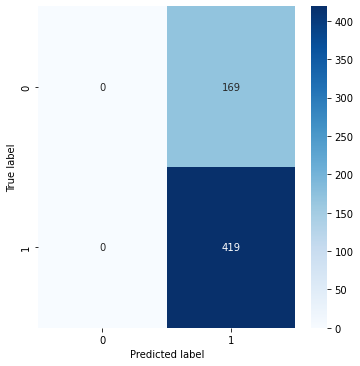

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

0.7899478894522036


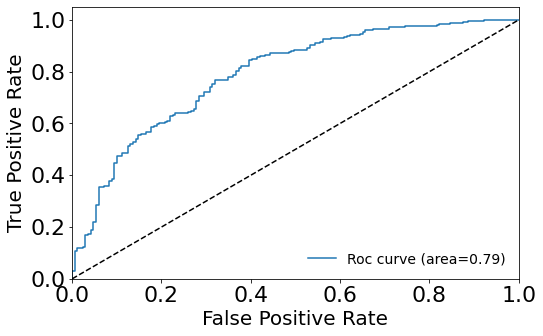

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

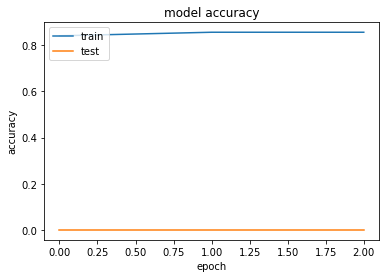

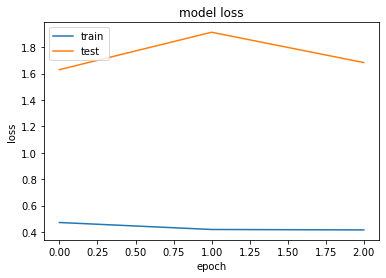

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
value = randint(0,len(X_test)) 
instance = X_test[value]
instance

'nordea see return positive growth baltic country 2011'

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model2.predict(instance)

array([[0.8142609]], dtype=float32)

# 66Agree

In [ ]:
train_file = 'without_test_66Agree_binary.txt'
test_file = 'test_set_binary.txt'
delimiter = ','

In [ ]:
df = pd.read_csv(train_file)

In [ ]:
df1 = pd.read_csv(test_file)

In [ ]:
X_train = list()
y_train = list()
with open(train_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_train.append(row[1])
        y_train.append(row[0])

X_test = list()
y_test = list()
with open(test_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_test.append(row[1])
        y_test.append(row[0])

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test)

(1683, 1683, 588, 588)

In [ ]:
y_train = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_train)))

In [ ]:
y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_test)))

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_test1 = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Simple Neural Network

In [ ]:
model4 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model4.add(embedding_layer)

model4.add(Flatten())
model4.add(Dense(1, activation='sigmoid'))

In [ ]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          544200    
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 554,201
Trainable params: 10,001
Non-trainable params: 544,200
_________________________________________________________________
None


In [ ]:
history = model4.fit(X_train1, y_train, batch_size=32, epochs=6, verbose=1,callbacks=[early_stopping], validation_split=0.2)

Epoch 1/6
43/43 [==============================] - 1s 5ms/step - loss: 0.4713 - acc: 0.8172 - val_loss: 1.6137 - val_acc: 0.1335
Epoch 2/6
43/43 [==============================] - 0s 3ms/step - loss: 0.3666 - acc: 0.8403 - val_loss: 1.7342 - val_acc: 0.1335
Epoch 3/6
43/43 [==============================] - 0s 3ms/step - loss: 0.3172 - acc: 0.8522 - val_loss: 1.6429 - val_acc: 0.1424
Epoch 4/6
43/43 [==============================] - 0s 3ms/step - loss: 0.2772 - acc: 0.8759 - val_loss: 1.6210 - val_acc: 0.1484
Epoch 5/6
43/43 [==============================] - 0s 3ms/step - loss: 0.2484 - acc: 0.8908 - val_loss: 1.6257 - val_acc: 0.1543
Epoch 6/6
43/43 [==============================] - 0s 3ms/step - loss: 0.2237 - acc: 0.9086 - val_loss: 1.7786 - val_acc: 0.1513


In [ ]:
score = model4.evaluate(X_test1, y_test, verbose=1)

19/19 [==============================] - 0s 2ms/step - loss: 0.5927 - acc: 0.7245


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5927439332008362
Test Accuracy: 0.7244898080825806


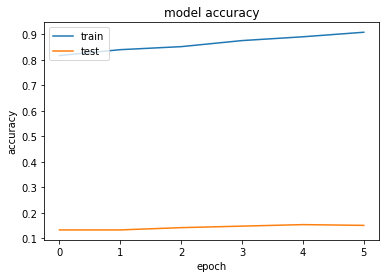

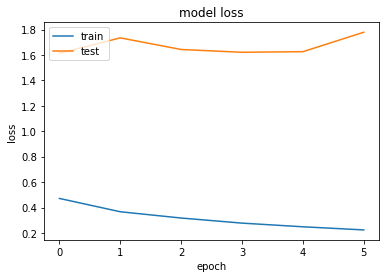

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
model5 = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model5.add(embedding_layer)

model5.add(Conv1D(128, 5, activation='relu'))
model5.add(GlobalMaxPooling1D())
model5.add(Dense(1, activation='sigmoid'))
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          544200    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 608,457
Trainable params: 64,257
Non-trainable params: 544,200
_________________________________________________________________
None


In [ ]:
num_epochs = 6
num_batch_size = 32

history = model5.fit(X_train1, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model5.evaluate(X_test1, y_test, verbose=1)

Epoch 1/6
43/43 [==============================] - 1s 15ms/step - loss: 0.4291 - acc: 0.8395 - val_loss: 2.2154 - val_acc: 0.1395
Epoch 2/6
43/43 [==============================] - 1s 12ms/step - loss: 0.2760 - acc: 0.8886 - val_loss: 2.0843 - val_acc: 0.1454
Epoch 3/6
43/43 [==============================] - 1s 13ms/step - loss: 0.1879 - acc: 0.9346 - val_loss: 1.9277 - val_acc: 0.1602
Epoch 4/6
43/43 [==============================] - 1s 13ms/step - loss: 0.1462 - acc: 0.9532 - val_loss: 2.6028 - val_acc: 0.1454
Epoch 5/6
43/43 [==============================] - 1s 14ms/step - loss: 0.1129 - acc: 0.9747 - val_loss: 1.6974 - val_acc: 0.2493
Epoch 6/6
19/19 [==============================] - 0s 5ms/step - loss: 0.5246 - acc: 0.7823


In [ ]:
yhat_probs = model5.predict(X_test1, verbose=0)
# predict classes for test set
yhat_classes = (model5.predict(X_test1) > 0.5).astype("int32")

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.782313
Precision: 0.775047
Recall: 0.978520
F1 score: 0.864979


In [ ]:
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.801316
[[ 50 119]
 [  9 410]]


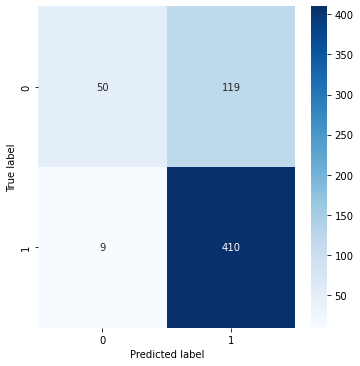

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred=model5.predict(X_test1)

0.8013161796895962


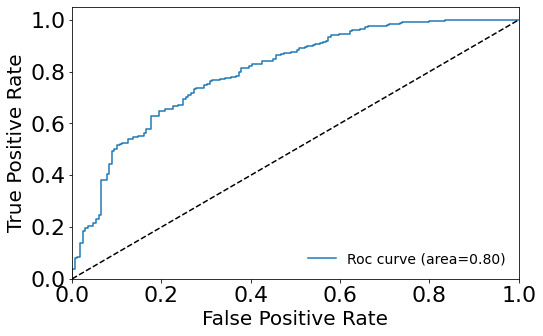

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# Recurrent Neural Network

In [ ]:
model6 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model6.add(embedding_layer)
model6.add(LSTM(128))

model6.add(Dense(1, activation='sigmoid'))
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          544200    
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 661,577
Trainable params: 117,377
Non-trainable params: 544,200
_________________________________________________________________
None


In [ ]:
history = model6.fit(X_train1, y_train, batch_size=32, epochs=8,validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model6.evaluate(X_test1, y_test, verbose=1)

Epoch 1/6
43/43 [==============================] - 5s 78ms/step - loss: 0.5138 - acc: 0.8135 - val_loss: 1.3140 - val_acc: 0.1335
Epoch 2/6
43/43 [==============================] - 3s 70ms/step - loss: 0.4705 - acc: 0.8269 - val_loss: 1.7845 - val_acc: 0.1335
Epoch 3/6
19/19 [==============================] - 1s 27ms/step - loss: 0.6298 - acc: 0.7126


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6297965049743652
Test Accuracy: 0.7125850319862366


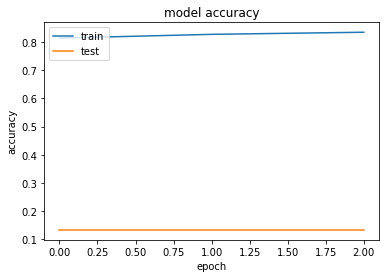

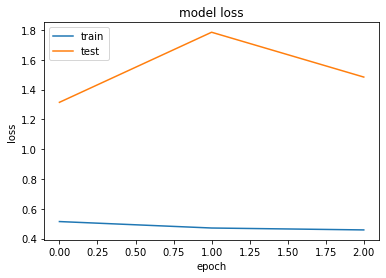

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

ROC AUC: 0.801316
[[ 50 119]
 [  9 410]]


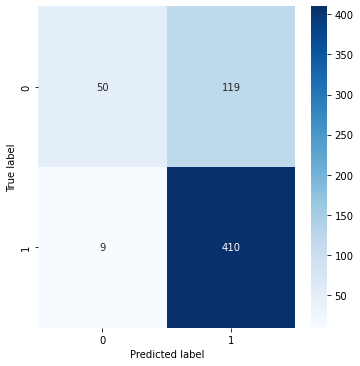

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred=model6.predict(X_test1)

0.605230825719168


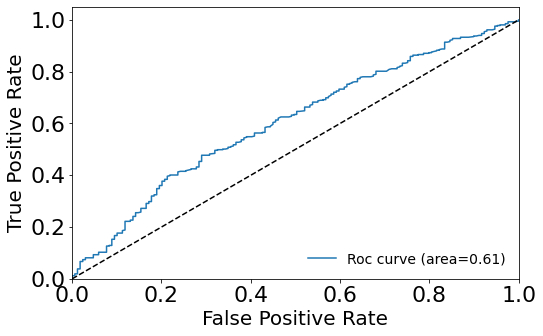

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# 75Agree

In [ ]:
train_file = 'without_test_75Agree_binary.txt'
test_file = 'test_set_binary.txt'
delimiter = ','

In [ ]:
df = pd.read_csv(train_file, skiprows=1)

In [ ]:
df.head()

,Sentiment,News
0,positive,with the new production plant the company woul...
1,positive,for the last quarter of 2010 componenta s net...
2,positive,in the third quarter of 2010 net sales increa...
3,positive,operating profit rose to eur 131 mn from eur 8...
4,positive,operating profit totalled eur 211 mn up from ...


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

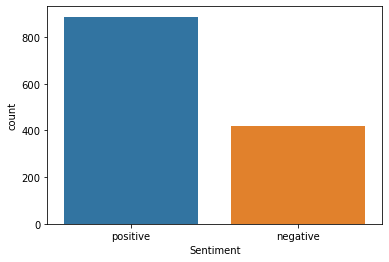

In [ ]:
sns.countplot(x='Sentiment', data=df)

In [ ]:
df1 = pd.read_csv(test_file)

In [ ]:
df1.head()

,Sentiment,News
0,negative,company say comparable operating profit januar...
1,positive,metso supply equipment two process line northl...
2,negative,staff reduction start immediately glaston add
3,positive,finland insurance company pohjola finnish moto...
4,positive,item include restructuring cost eur1 6 year ea...


In [ ]:
X_train = list()
y_train = list()
with open(train_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_train.append(row[1])
        y_train.append(row[0])

X_test = list()
y_test = list()
with open(test_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_test.append(row[1])
        y_test.append(row[0])

In [ ]:
y_train = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_train)))
y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_test)))

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_test1 = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Simple Neural Network

In [ ]:
model7 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model7.add(embedding_layer)

model7.add(Flatten())
model7.add(Dense(1, activation='sigmoid'))

In [ ]:
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model7.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          438100    
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 448,101
Trainable params: 10,001
Non-trainable params: 438,100
_________________________________________________________________
None


In [ ]:
history = model7.fit(X_train1, y_train, batch_size=32, epochs=8, verbose=1,callbacks=[early_stopping], validation_split=0.2)

Epoch 1/6
33/33 [==============================] - 1s 7ms/step - loss: 0.4941 - acc: 0.7992 - val_loss: 1.4814 - val_acc: 0.1260
Epoch 2/6
33/33 [==============================] - 0s 3ms/step - loss: 0.3825 - acc: 0.8356 - val_loss: 1.6985 - val_acc: 0.1298
Epoch 3/6
33/33 [==============================] - 0s 3ms/step - loss: 0.3324 - acc: 0.8537 - val_loss: 1.7400 - val_acc: 0.1412
Epoch 4/6
33/33 [==============================] - 0s 3ms/step - loss: 0.2978 - acc: 0.8652 - val_loss: 1.9637 - val_acc: 0.1336
Epoch 5/6
33/33 [==============================] - 0s 3ms/step - loss: 0.2664 - acc: 0.8967 - val_loss: 1.6788 - val_acc: 0.1679
Epoch 6/6
33/33 [==============================] - 0s 3ms/step - loss: 0.2452 - acc: 0.9025 - val_loss: 1.7457 - val_acc: 0.1718


In [ ]:
value = randint(0,len(X_test)) 
instance = X_test[value].lower()
instance

'current year raute expect net sale increase operating result  positive'

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

predictions = model7.predict(instance)
y_pred = (predictions > 0.5)

In [ ]:
score = model7.evaluate(X_test1, y_test, verbose=1)

19/19 [==============================] - 0s 2ms/step - loss: 0.5820 - acc: 0.7126


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.582003116607666
Test Accuracy: 0.7125850319862366


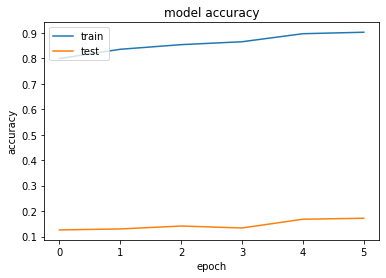

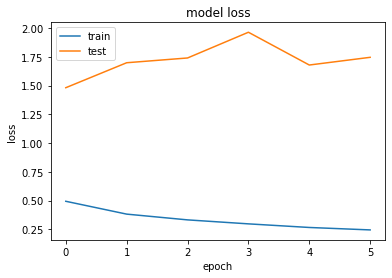

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
model8 = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model8.add(embedding_layer)

model8.add(Conv1D(128, 5, activation='relu'))
model8.add(GlobalMaxPooling1D())
model8.add(Dense(1, activation='sigmoid'))
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          438100    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 502,357
Trainable params: 64,257
Non-trainable params: 438,100
_________________________________________________________________
None


In [ ]:
num_epochs = 6
num_batch_size = 32

history = model8.fit(X_train1, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model8.evaluate(X_test1, y_test, verbose=1)

Epoch 1/6
33/33 [==============================] - 1s 16ms/step - loss: 0.4551 - acc: 0.8250 - val_loss: 1.3493 - val_acc: 0.1374
Epoch 2/6
33/33 [==============================] - 0s 13ms/step - loss: 0.3021 - acc: 0.8709 - val_loss: 1.5314 - val_acc: 0.1412
Epoch 3/6
33/33 [==============================] - 0s 12ms/step - loss: 0.2177 - acc: 0.9149 - val_loss: 1.8690 - val_acc: 0.1412
Epoch 4/6
19/19 [==============================] - 0s 4ms/step - loss: 0.6411 - acc: 0.7228


In [ ]:
yhat_probs = model8.predict(X_test1, verbose=0)
# predict classes for test set
yhat_classes = (model8.predict(X_test1) > 0.5).astype("int32")

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.722789
Precision: 0.720690
Recall: 0.997613
F1 score: 0.836837


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.054532
ROC AUC: 0.771081
[[  7 162]
 [  1 418]]


In [ ]:
y_pred=model8.predict(X_test1)

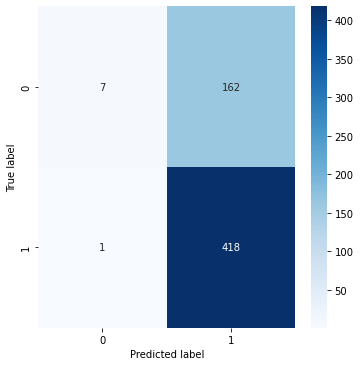

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

0.7710807642880344


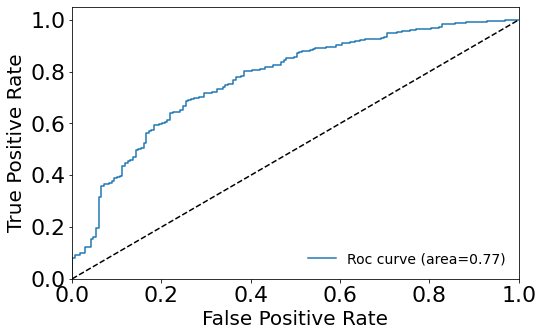

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# LSTM

In [ ]:
model9 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model9.add(embedding_layer)
model9.add(LSTM(128))

model9.add(Dense(1, activation='sigmoid'))
model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          438100    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 502,357
Trainable params: 64,257
Non-trainable params: 438,100
_________________________________________________________________
None


In [ ]:
history = model9.fit(X_train1, y_train, batch_size=32, epochs=10, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model9.evaluate(X_test1, y_test, verbose=1)

Epoch 1/10
33/33 [==============================] - 4s 83ms/step - loss: 0.5357 - acc: 0.8050 - val_loss: 1.3670 - val_acc: 0.1183
Epoch 2/10
33/33 [==============================] - 2s 70ms/step - loss: 0.4885 - acc: 0.8184 - val_loss: 1.3870 - val_acc: 0.1183
Epoch 3/10
19/19 [==============================] - 0s 25ms/step - loss: 0.6123 - acc: 0.7126


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6123079061508179
Test Accuracy: 0.7125850319862366


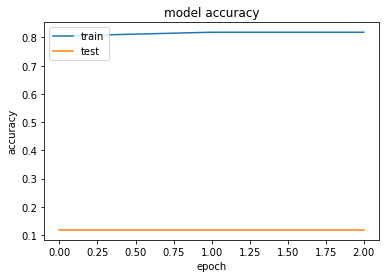

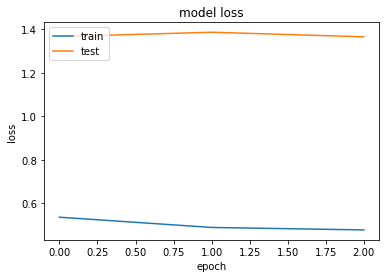

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
value = randint(0,len(X_test)) 
instance = X_test[value]
instance

'atria launch campaign september promote campomos brand moscow market say'

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model9.predict(instance)

array([[0.7811104]], dtype=float32)

# Allagree

In [ ]:
train_file = 'without_test_AllAgree_binary.txt'
test_file = 'test_set_binary.txt'
delimiter = ','

In [ ]:
df = pd.read_csv(train_file,skiprows=1)

In [ ]:
df.head()

,Sentiment,News
0,positive,for the last quarter of 2010 componenta s net...
1,positive,in the third quarter of 2010 net sales increa...
2,positive,operating profit rose to eur 131 mn from eur 8...
3,positive,operating profit totalled eur 211 mn up from ...
4,positive,finnish talentum reports its operating profit ...


In [ ]:
df1 = pd.read_csv(test_file)

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

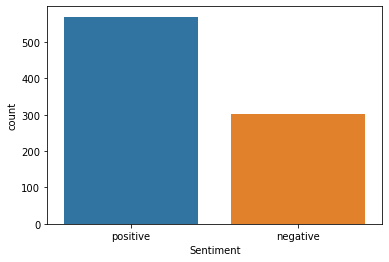

In [ ]:
sns.countplot(x='Sentiment', data=df)

In [ ]:
X_train = list()
y_train = list()
with open(train_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_train.append(row[1])
        y_train.append(row[0])

X_test = list()
y_test = list()
with open(test_file, encoding='utf-8', newline='') as infile:
    next(infile)
    reader = csv.reader(infile, delimiter=delimiter)
    for row in reader:
        X_test.append(row[1])
        y_test.append(row[0])

In [ ]:
y_train = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_train)))
y_test = np.array(list(map(lambda x: 1 if x=="positive" else 0, y_test)))

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_test1 = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Simple Neural Network

In [ ]:
model10 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model10.add(embedding_layer)

model10.add(Flatten())
model10.add(Dense(1, activation='sigmoid'))

In [ ]:
model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model10.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          302800    
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 312,801
Trainable params: 10,001
Non-trainable params: 302,800
_________________________________________________________________
None


In [ ]:
history = model10.fit(X_train1, y_train, batch_size=32, epochs=6, verbose=1,callbacks=[early_stopping], validation_split=0.2)

Epoch 1/6
22/22 [==============================] - 1s 8ms/step - loss: 0.5297 - acc: 0.7797 - val_loss: 1.5505 - val_acc: 0.0286
Epoch 2/6
22/22 [==============================] - 0s 4ms/step - loss: 0.4060 - acc: 0.8197 - val_loss: 1.8250 - val_acc: 0.0171
Epoch 3/6
22/22 [==============================] - 0s 4ms/step - loss: 0.3466 - acc: 0.8541 - val_loss: 1.8754 - val_acc: 0.0229


In [ ]:
value = randint(0,len(X_test)) 
instance = X_test[value]
instance

'operating profit total eur 55 mn eur 07 mn'

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

predictions = model10.predict(instance)
y_pred = (predictions > 0.5)

In [ ]:
score = model9.evaluate(X_test1, y_test, verbose=1)

19/19 [==============================] - 1s 27ms/step - loss: 0.6123 - acc: 0.7126


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6123340725898743
Test Accuracy: 0.7125850319862366


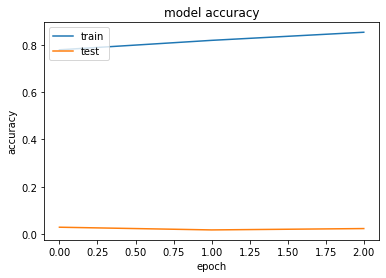

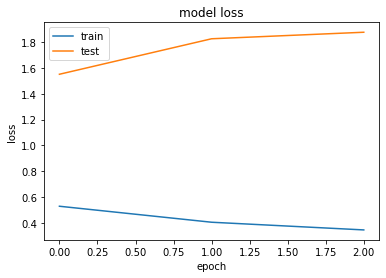

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Convolutional Neural Network

In [ ]:
model11 = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model11.add(embedding_layer)

model11.add(Conv1D(128, 5, activation='relu'))
model11.add(GlobalMaxPooling1D())
model11.add(Dense(1, activation='sigmoid'))
model11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model11.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          302800    
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 367,057
Trainable params: 64,257
Non-trainable params: 302,800
_________________________________________________________________
None


In [ ]:
num_epochs = 6
num_batch_size = 32

history = model11.fit(X_train1, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model11.evaluate(X_test1, y_test, verbose=1)

Epoch 1/6
22/22 [==============================] - 1s 19ms/step - loss: 0.5149 - acc: 0.8054 - val_loss: 2.1811 - val_acc: 0.0171
Epoch 2/6
22/22 [==============================] - 0s 13ms/step - loss: 0.3371 - acc: 0.8541 - val_loss: 1.8597 - val_acc: 0.0343
Epoch 3/6
22/22 [==============================] - 0s 15ms/step - loss: 0.2710 - acc: 0.8827 - val_loss: 2.0974 - val_acc: 0.0343
Epoch 4/6
22/22 [==============================] - 0s 13ms/step - loss: 0.2232 - acc: 0.9142 - val_loss: 1.2373 - val_acc: 0.1429
Epoch 5/6
22/22 [==============================] - 0s 13ms/step - loss: 0.1799 - acc: 0.9499 - val_loss: 2.4832 - val_acc: 0.0343
Epoch 6/6
19/19 [==============================] - 0s 5ms/step - loss: 0.6148 - acc: 0.7228


In [ ]:
yhat_probs = model11.predict(X_test1, verbose=0)
# predict classes for test set
yhat_classes = (model11.predict(X_test1) > 0.5).astype("int32")

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.722789
Precision: 0.719931
Recall: 1.000000
F1 score: 0.837163


In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.049845
ROC AUC: 0.744348
[[  6 163]
 [  0 419]]


In [ ]:
y_pred=model11.predict(X_test1)

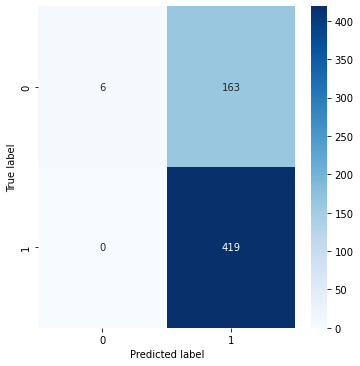

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

0.7443476296055697


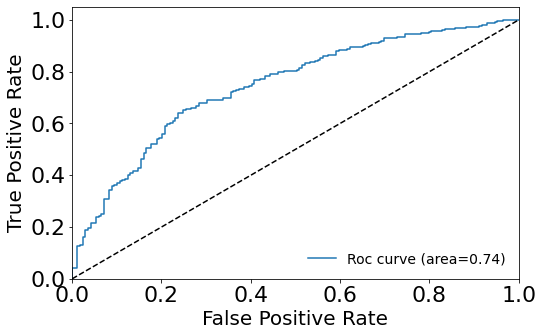

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()

# LSTM

In [ ]:
model12 = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model12.add(embedding_layer)
model12.add(LSTM(128))

model12.add(Dense(1, activation='sigmoid'))
model12.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model12.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          302800    
                                                                 
 lstm_3 (LSTM)               (None, 128)               117248    
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 420,177
Trainable params: 117,377
Non-trainable params: 302,800
_________________________________________________________________
None


In [ ]:
history = model12.fit(X_train1, y_train, batch_size=32, epochs=10, validation_split=0.2,callbacks=[early_stopping], verbose=1)

score = model12.evaluate(X_test1, y_test, verbose=1)

Epoch 1/10
22/22 [==============================] - 4s 91ms/step - loss: 0.5599 - acc: 0.7954 - val_loss: 1.2059 - val_acc: 0.0171
Epoch 2/10
22/22 [==============================] - 2s 69ms/step - loss: 0.4991 - acc: 0.8112 - val_loss: 1.2838 - val_acc: 0.0171
Epoch 3/10
19/19 [==============================] - 1s 27ms/step - loss: 0.6379 - acc: 0.7126


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.637870192527771
Test Accuracy: 0.7125850319862366


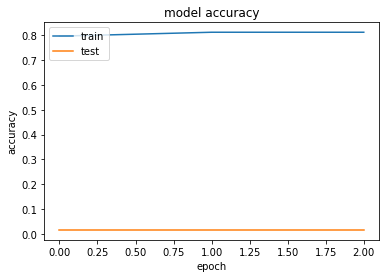

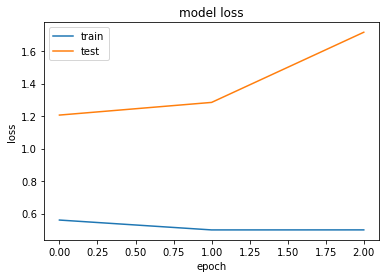

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.049845
ROC AUC: 0.744348
[[  6 163]
 [  0 419]]


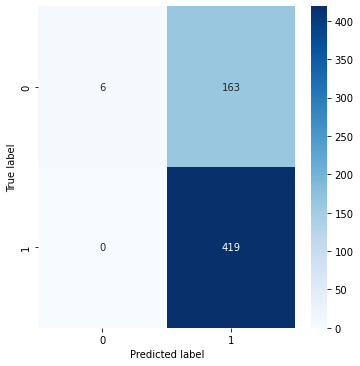

In [ ]:
figure = plt.figure(figsize=(5,5))
sns.heatmap(matrix, annot=True,cmap='Blues',fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
y_pred=model12.predict(X_test1)

0.6610978520286396


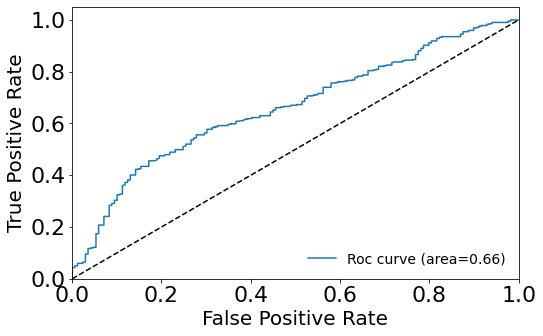

In [ ]:
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=metrics.auc(fpr,tpr)
print(roc_auc)
plt.figure(figsize=(8,5))
plt.plot(fpr,tpr,label='Roc curve (area=%0.2f)'%(roc_auc))

plt.plot([0,1],[0,1], 'k--' )
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=22)
plt.legend(loc='lower right', fontsize=14, frameon=False)
plt.show()